### Importações e Configurações

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [40]:
# Caminho para Salvar os Dados

path_metrics = './outputs/metrics/'
path_img = './outputs/plots/'

### Carregamento dos Dados com Engenharia de Atributos

In [29]:
df = pd.read_csv('../3_feature_engineering/outputs/data/df_features.csv', parse_dates=['Date'], delimiter=',')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,week,week_sin,week_cos,is_holiday,holiday_week,rolling_mean_4,lag_1,lag_52,Type_B,Type_C
0,1,1,2011-02-04,21665.76,False,42.27,2.989,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,18707.0275,18461.18,24924.50,False,False
1,1,1,2011-02-11,37887.17,True,36.39,3.022,0.0,0.0,0.0,...,6,0.663123,0.748511,1,6,23838.8950,21665.76,46039.49,False,False
2,1,1,2011-02-18,46845.87,False,57.36,3.045,0.0,0.0,0.0,...,7,0.748511,0.663123,0,0,31214.9950,37887.17,41595.55,False,False
3,1,1,2011-02-25,19363.83,False,62.90,3.065,0.0,0.0,0.0,...,8,0.822984,0.568065,0,0,31440.6575,46845.87,19403.54,False,False
4,1,1,2011-03-04,20327.61,False,59.58,3.288,0.0,0.0,0.0,...,9,0.885456,0.464723,0,0,31106.1200,19363.83,21827.90,False,False


### Seleção de Target e Features

In [30]:
target = "Weekly_Sales_log"

features = [
    col for col in df.columns
    if col not in ["Weekly_Sales", "Weekly_Sales_log", "Date"]
]

X = df[features].astype(float).values
y = df[target].astype(float).values


A variável alvo escolhida foi o logaritmo das vendas semanais (`Weekly_Sales_log`), estratégia adotada para estabilizar a variância e reduzir o impacto de outliers extremos. As features incluem todas as variáveis numéricas e categóricas previamente transformadas, excluindo apenas a data e as versões não transformadas do target.

### Divisão Temporal

In [31]:
n = len(X)
train_end = int(n * 0.8)

X_train = X[:train_end]
y_train = y[:train_end]

X_test = X[train_end:]
y_test = y[train_end:]

A divisão dos dados segue um critério estritamente temporal, utilizando 80% das observações iniciais para treino e os 20% finais para teste. Essa abordagem evita vazamento de informação futura e reflete um cenário realista de previsão de séries temporais.

### Estimativa dos parâmetros (Naive Bayes Gaussiano)

In [32]:
class NaiveBayesRegressor:
    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        self.mu_y = np.mean(y)
        self.sigma_y = np.std(y)

        self.mu_x = np.mean(X, axis=0)
        self.sigma_x = np.std(X, axis=0)

        cov = np.cov(X.T, y)
        self.beta = cov[:-1, -1] / np.var(X, axis=0)

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return self.mu_y + (X - self.mu_x) @ self.beta

    def predict_distribution(self, X, n_samples=1000):
        preds = self.predict(X)
        return np.random.normal(
            loc=preds[:, None],
            scale=self.sigma_y,
            size=(len(preds), n_samples)
        )

Nesta célula é implementado um modelo Naive Bayes Gaussiano do zero, assumindo independência condicional entre as features. O modelo estima:

- Média e desvio padrão das features
- Média e variância da variável alvo
- Coeficientes lineares derivados da covariância entre cada feature e o target

Essa formulação aproxima o Naive Bayes de um modelo estatístico explicativo, permitindo interpretar diretamente o impacto médio das variáveis sobre o valor esperado das vendas.

### Treino do Modelo

In [33]:
nb_model = NaiveBayesRegressor()
nb_model.fit(X_train, y_train)

O modelo Naive Bayes é ajustado utilizando apenas o conjunto de treino temporal. Nesta etapa são aprendidos os parâmetros estatísticos globais que serão utilizados para gerar previsões pontuais e distribuições preditivas no conjunto de teste.

### Predição + IC no Conjunto de Teste

In [34]:
# Função Intervalo de Confiança

def confidence_interval(pred_dist, alpha=0.05):
    lower = np.percentile(pred_dist, 100 * alpha / 2)
    upper = np.percentile(pred_dist, 100 * (1 - alpha / 2))
    median = np.percentile(pred_dist, 50)
    return lower, median, upper

In [45]:
y_pred_nb = nb_model.predict(X_test) 

pred_dist = nb_model.predict_distribution(X_test) 
ci = np.percentile( pred_dist, [2.5, 50, 97.5], axis=1 ).T

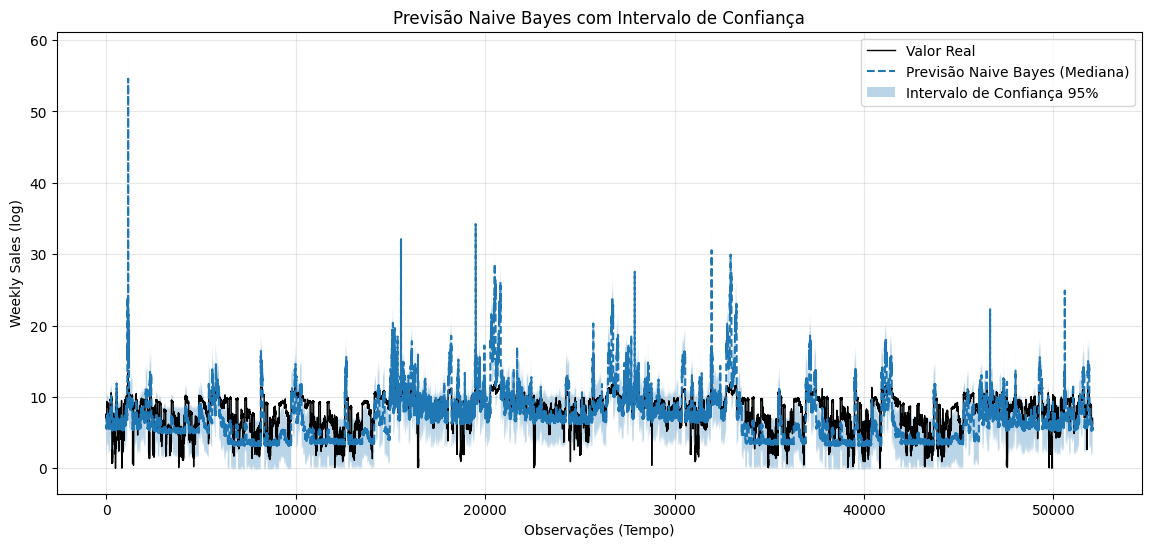

In [46]:
# Gráfico do Intervalo de Confiança

plt.figure(figsize=(14, 6))

# Série real
plt.plot(
    y_test,
    label="Valor Real",
    color="black",
    linewidth=1
)

# Previsão (mediana)
plt.plot(
    y_pred_nb,
    label="Previsão Naive Bayes (Mediana)",
    linestyle="--"
)

# Intervalo de confiança
plt.fill_between(
    np.arange(len(y_test)),
    ci[:, 0],  # limite inferior
    ci[:, 2],  # limite superior
    alpha=0.3,
    label="Intervalo de Confiança 95%"
)

plt.title("Previsão Naive Bayes com Intervalo de Confiança")
plt.xlabel("Observações (Tempo)")
plt.ylabel("Weekly Sales (log)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f'{path_img}Intervalo_de_Confianca.png', dpi=300, bbox_inches='tight')
plt.show()

O gráfico acima apresenta a previsão do modelo Naive Bayes Regressor acompanhada de um intervalo de confiança de 95%, permitindo avaliar não apenas o valor central estimado, mas também a incerteza associada a cada predição.

Observa-se que a faixa de incerteza é relativamente ampla ao longo de toda a série temporal, o que indica que o modelo possui elevada variabilidade nas estimativas. Isso é esperado, uma vez que o Naive Bayes assume independência condicional entre as variáveis explicativas, hipótese forte que não se sustenta plenamente em um contexto de vendas semanais, onde fatores econômicos, sazonais e operacionais tendem a ser altamente correlacionados.

A mediana das previsões acompanha a tendência média da série, porém apresenta dificuldade em capturar picos e quedas abruptas observados nos valores reais. A largura do intervalo de confiança reforça que o modelo é mais adequado para fornecer uma visão estatística global da distribuição esperada das vendas do que previsões pontuais de alta precisão.

Dessa forma, o intervalo de confiança cumpre um papel fundamental ao explicitar o grau de incerteza do modelo, destacando suas limitações para aplicações operacionais e sua utilidade como ferramenta exploratória e estatística no entendimento do comportamento das vendas.

In [36]:
confidence_interval(pred_dist)

(np.float64(1.2007427038275273),
 np.float64(6.469615224944656),
 np.float64(16.16311109552106))

O intervalo de confiança global calculado a partir da distribuição preditiva indica que, com 95% de confiança, os valores previstos de vendas (em escala logarítmica) situam-se aproximadamente entre 1.20 e 16.16, com uma mediana em torno de 6.47.

Esse intervalo relativamente amplo evidencia a elevada incerteza do modelo Naive Bayes ao estimar valores individuais de vendas. A mediana representa a estimativa central do modelo, enquanto os limites inferior e superior refletem a dispersão significativa das previsões.

No contexto de previsão de vendas, esse resultado reforça que o modelo não deve ser interpretado como um preditor preciso de valores pontuais, mas sim como uma aproximação estatística da faixa na qual as vendas tendem a se concentrar. A amplitude do intervalo está diretamente relacionada à simplicidade do modelo e às hipóteses de independência entre as variáveis, que limitam sua capacidade de capturar interações complexas presentes nos dados reais.

Assim, o intervalo de confiança global contribui para a análise ao quantificar explicitamente a incerteza do modelo, complementando métricas tradicionais como RMSE e R² e oferecendo uma perspectiva probabilística relevante para a tomada de decisão.


### Avaliação das Métricas

In [37]:
# Salvando Métricas do Naives Bayes

nb_metrics = {
    "RMSE": float(np.sqrt(mean_squared_error(y_test, y_pred_nb))),
    "MAE": float(mean_absolute_error(y_test, y_pred_nb)),
    "R2": float(r2_score(y_test, y_pred_nb))
}

metrics_json = {
    "model_name": "Naives Bayes",
    "metrics": nb_metrics
}

output_path = f'{path_metrics}Naive_Bayes_metrics.json'

with open(output_path, "w") as f:
    json.dump(metrics_json, f, indent=4)

print(f"Métricas salvas em {output_path}")
print(nb_metrics)


Métricas salvas em ./outputs/metrics/Naive_Bayes_metrics.json
{'RMSE': 2.648974966941372, 'MAE': 2.072753550300755, 'R2': -0.42070824597843814}


Os resultados obtidos indicam desempenho inferior aos modelos mais complexos avaliados no projeto:

- **RMSE elevado** indica erro médio significativo na escala do target
- **MAE elevado** confirma baixa precisão média das previsões
- **R² negativo (-0.42)** revela que o modelo não supera uma predição ingênua baseada apenas na média histórica

Esse comportamento era esperado, dado que o Naive Bayes impõe hipóteses fortes de independência entre variáveis, pouco realistas para este problema altamente correlacionado. Ainda assim, o modelo cumpre um papel didático importante ao demonstrar uma abordagem estatística probabilística completa, incluindo estimativas de incerteza.